In [1]:
import os
import sys
import glob

sys.path.append(os.getcwd())

import torch
from enc.component.coolchic import CoolChicEncoderParameter
from enc.component.frame import load_frame_encoder
from enc.component.intercoding.warp import WarpParameter
from enc.component.types import NAME_COOLCHIC_ENC
from lossless.component.image import (
    FrameEncoderManager,
    encode_one_frame,
)
from enc.utils.codingstructure import CodingStructure, Frame
from typing import Any, Dict, List

DATASET_PATH = f"{os.getcwd()}/../datasets/kodak"
IMAGE_PATHS = sorted(
    glob.glob(f"{DATASET_PATH}/*.png"),
    key=lambda x: int(os.path.basename(x).split(".")[0][len("kodim") :]),
)
TEST_WORKDIR = f"{os.getcwd()}/test-workdir/"
PATH_COOL_CHIC_CFG = f"{os.getcwd()}/../cfg/"
print(IMAGE_PATHS)

args = {
    # not in config files
    "input": IMAGE_PATHS[0],
    "output": TEST_WORKDIR + "/output",
    "workdir": TEST_WORKDIR,
    "lmbda": 1e-3,
    "job_duration_min": -1,
    "print_detailed_archi": False,
    "print_detailed_struct": False,
    "intra_pos": "0",
    "p_pos": "",
    "n_frames": 1,
    "frame_offset": 0,
    "coding_idx": 0,
    # config file paths
    # "enc_cfg": f"{PATH_COOL_CHIC_CFG}enc/intra/fast_10k.cfg",
    # "dec_cfg_residue": f"{PATH_COOL_CHIC_CFG}dec/intra_residue/lop.cfg",
    # "dec_cfg_motion": f"{PATH_COOL_CHIC_CFG}dec/motion/lop.cfg",
    # args in config files
    # encoder side
    "start_lr": 1e-2,
    "n_itr": int(1e3),
    "n_itr_pretrain_motion": int(1e2),
    "n_train_loops": 1,
    "preset": "c3x_intra",
    # decoder side
    "layers_synthesis_residue": "48-1-linear-relu,X-1-linear-none,X-3-residual-relu,X-3-residual-none",
    "arm_residue": "16,2",
    "n_ft_per_res_residue": "1,1,1,1,1,1,1",
    "ups_k_size_residue": 8,
    "ups_preconcat_k_size_residue": 7,
    "warp_filter_size": 8,
    # "layers_synthesis_motion": "9-1-linear-relu,X-1-linear-none,X-3-residual-none",
    # "arm_motion": "8,1",
    # "n_ft_per_res_motion": "0,0,1,1,1,1,1",
    # "ups_k_size_motion": 8,
    # "ups_preconcat_k_size_motion": 7,
}

print(args)
print("----------")
os.chdir(args["workdir"])

start_print = (
    "\n\n"
    "*----------------------------------------------------------------------------------------------------------*\n"
    "|                                                                                                          |\n"
    "|                                                                                                          |\n"
    "|       ,gggg,                                                                                             |\n"
    '|     ,88"""Y8b,                           ,dPYb,                             ,dPYb,                       |\n'
    "|    d8\"     `Y8                           IP'`Yb                             IP'`Yb                       |\n"
    "|   d8'   8b  d8                           I8  8I                             I8  8I      gg               |\n"
    "|  ,8I    \"Y88P'                           I8  8'                             I8  8'      \"\"               |\n"
    "|  I8'             ,ggggg,      ,ggggg,    I8 dP      aaaaaaaa        ,gggg,  I8 dPgg,    gg     ,gggg,    |\n"
    '|  d8             dP"  "Y8ggg  dP"  "Y8ggg I8dP       """"""""       dP"  "Yb I8dP" "8I   88    dP"  "Yb   |\n'
    "|  Y8,           i8'    ,8I   i8'    ,8I   I8P                      i8'       I8P    I8   88   i8'         |\n"
    "|  `Yba,,_____, ,d8,   ,d8'  ,d8,   ,d8'  ,d8b,_                   ,d8,_    _,d8     I8,_,88,_,d8,_    _   |\n"
    '|    `"Y8888888 P"Y8888P"    P"Y8888P"    8P\'"Y88                  P""Y8888PP88P     `Y88P""Y8P""Y8888PP   |\n'
    "|                                                                                                          |\n"
    "|                                                                                                          |\n"
    "| version 4.1.0, July 2025                                                              © 2023-2025 Orange |\n"
    "*----------------------------------------------------------------------------------------------------------*\n"
)

['/home/jakub/ETH/2025_2026_fall/thesis/Cool-Chic/coolchic/../datasets/kodak/kodim01.png', '/home/jakub/ETH/2025_2026_fall/thesis/Cool-Chic/coolchic/../datasets/kodak/kodim02.png', '/home/jakub/ETH/2025_2026_fall/thesis/Cool-Chic/coolchic/../datasets/kodak/kodim03.png', '/home/jakub/ETH/2025_2026_fall/thesis/Cool-Chic/coolchic/../datasets/kodak/kodim04.png', '/home/jakub/ETH/2025_2026_fall/thesis/Cool-Chic/coolchic/../datasets/kodak/kodim05.png', '/home/jakub/ETH/2025_2026_fall/thesis/Cool-Chic/coolchic/../datasets/kodak/kodim06.png', '/home/jakub/ETH/2025_2026_fall/thesis/Cool-Chic/coolchic/../datasets/kodak/kodim07.png', '/home/jakub/ETH/2025_2026_fall/thesis/Cool-Chic/coolchic/../datasets/kodak/kodim08.png', '/home/jakub/ETH/2025_2026_fall/thesis/Cool-Chic/coolchic/../datasets/kodak/kodim09.png', '/home/jakub/ETH/2025_2026_fall/thesis/Cool-Chic/coolchic/../datasets/kodak/kodim10.png', '/home/jakub/ETH/2025_2026_fall/thesis/Cool-Chic/coolchic/../datasets/kodak/kodim11.png', '/home/ja

In [2]:
# UTIL CODE

def pretty_str_dict(d: dict[str, Any]) -> str:
    if not d:
        return ""
    
    # Find length of the longest key
    max_key_len = max(len(k) for k in d.keys())
    
    lines = []
    for key, value in d.items():
        # Pad key so values align, ensure at least one space after colon
        lines.append(f"{key}:{' ' * (max_key_len - len(key) + 1)}{value}")
    
    return "\n".join(lines)

In [3]:
# COOL CHICK PARAMETER PARSER CODE
def parse_frame_pos(frame_pos_str: str, n_frames: int) -> list[int]:
    """Parse the command line arguments for --intra_pos or --p_pos.

    Format:
    -------

        Format is 0,4,7 if you want the frame 0, 4 and 7 to be intra frames.

        -1 can be used to denote the last frame, -2 the 2nd to last etc.

        x-y is a range from x (included) to y (included). This does not work
        with the negative indexing.

        0,4-7,-2 ==> Intra for the frame 0, 4, 5, 6, 7 and the 2nd to last."

    Args:
        frame_pos_str: Command line arguments.
        n_frames: Number of frames to code. Correspond to --n_frames and
            it is required to handle negative indexing

    Returns:
        List[int]: List of frame positions by display order.
    """
    if frame_pos_str == "":
        return []

    pos = []
    for tmp in frame_pos_str.split(","):
        if tmp == "":
            continue

        # Positive or negative integer
        try:
            tmp_int = int(tmp)
            if tmp_int < 0:
                tmp_int = n_frames - abs(tmp_int)
            pos.append(tmp_int)

        # Range x-y
        except ValueError:
            start, end = [int(x) for x in tmp.split("-")]
            for x in range(start, end + 1):
                pos.append(x)

    pos.sort()
    return pos


def get_coding_structure_from_args(args: dict) -> dict[str, Any]:
    """Perform some check on the argparse object used to collect the command
    line parameters. Return a dictionary ready to be plugged into the
    ``CodingStructure`` constructor.

    Args:
        args (argparse.Namespace): Command-line argument parser.

    Returns:
        Dict[str, Any]: Dictionary ready to be plugged into the ``CodingStructure``
            constructor.
    """
    n_frames = args["n_frames"]
    frame_offset = args["frame_offset"]

    assert (
        n_frames > 0
    ), f"There must be at least one frame to encode. Found --n_frames={n_frames}"

    assert (
        frame_offset >= 0
    ), f"Negative frame_offset is not possible. Found --frame_offset={frame_offset}"

    coding_structure_config = {
        "n_frames": n_frames,
        "intra_pos": parse_frame_pos(args["intra_pos"], n_frames),
        "p_pos": parse_frame_pos(args["p_pos"], n_frames),
        "seq_name": (
            os.path.basename(args["input"]).split(".")[0]
            if "input" in args
            else ""
        ),
        "frame_offset": frame_offset,
    }
    return coding_structure_config


def parse_synthesis_layers(layers_synthesis: str) -> List[str]:
    """The layers of the synthesis are presented in as a coma-separated string.
    This simply splits up the different substrings and return them.

    Args:
        layers_synthesis (str): Command line argument for the synthesis.

    Returns:
        List[str]: List of string where the i-th element described the i-th
            synthesis layer
    """
    parsed_layer_synth = [x for x in layers_synthesis.split(",") if x != ""]

    assert parsed_layer_synth, (
        "Synthesis should have at least one layer, found nothing. \n"
        f"--layers_synthesis={layers_synthesis} does not work!\n"
        "Try something like 32-1-linear-relu,X-1-linear-none,"
        "X-3-residual-relu,X-3-residual-none"
    )

    return parsed_layer_synth


def parse_n_ft_per_res(n_ft_per_res: str) -> list[int]:
    """The number of feature per resolution is a coma-separated string.
    This simply splits up the different substrings and return them.

    Args:
        n_ft_per_res (str): Something like "1,1,1,1,1,1,1" for 7 latent grids
        with different resolution and 1 feature each.

    Returns:
        List[int]: The i-th element is the number of features for the i-th
        latent, i.e. the latent of a resolution (H / 2^i, W / 2^i).
    """

    n_ft_per_res_int = [int(x) for x in n_ft_per_res.split(",") if x != ""]
    # assert set(n_ft_per_res) == {
    #     1
    # }, f"--n_ft_per_res should only contains 1. Found {n_ft_per_res}"
    return n_ft_per_res_int


def parse_arm_archi(arm: str) -> Dict[str, int]:
    """The arm is described as <dim_arm>,<n_hidden_layers_arm>.
    Split up this string to return the value as a dict.

    Args:
        arm (str): Command line argument for the ARM.

    Returns:
        Dict[str, int]: The ARM architecture
    """
    assert len(arm.split(",")) == 2, (
        f"--arm format should be X,Y." f" Found {arm}"
    )

    dim_arm, n_hidden_layers_arm = [int(x) for x in arm.split(",")]
    arm_param = {"dim_arm": dim_arm, "n_hidden_layers_arm": n_hidden_layers_arm}
    return arm_param


def get_coolchic_param_from_args(
    args: dict,
    coolchic_enc_name: str,
) -> Dict[str, Any]:
    layers_synthesis = parse_synthesis_layers(
        args[f"layers_synthesis_{coolchic_enc_name}"]
    )
    n_ft_per_res = parse_n_ft_per_res(args[f"n_ft_per_res_{coolchic_enc_name}"])

    coolchic_param = {
        "layers_synthesis": layers_synthesis,
        "n_ft_per_res": n_ft_per_res,
        "ups_k_size": args[f"ups_k_size_{coolchic_enc_name}"],
        "ups_preconcat_k_size": args[
            f"ups_preconcat_k_size_{coolchic_enc_name}"
        ],
    }

    # Add ARM parameters
    coolchic_param.update(parse_arm_archi(args[f"arm_{coolchic_enc_name}"]))

    return coolchic_param


def get_manager_from_args(args: dict) -> Dict[str, Any]:
    """Perform some check on the argparse object used to collect the command
    line parameters. Return a dictionary ready to be plugged into the
    ``FrameEncoderManager`` constructor.

    Args:
        args (argparse.Namespace): Command-line argument parser.

    Returns:
        Dict[str, Any]: Dictionary ready to be plugged into the
            ``FrameEncoderManager`` constructor.
    """
    frame_encoder_manager = {
        "preset_name": args["preset"],
        "start_lr": args["start_lr"],
        "lmbda": args["lmbda"],
        "n_loops": args["n_train_loops"],
        "n_itr": args["n_itr"],
        "n_itr_pretrain_motion": args["n_itr_pretrain_motion"],
    }
    return frame_encoder_manager


def get_warp_param_from_args(args: dict) -> Dict[str, Any]:
    """Perform some check on the argparse object used to collect the command
    line parameters. Return a dictionary ready to be plugged into the
    ``WarpParameter`` constructor.

    Args:
        args (argparse.Namespace): Command-line argument parser.

    Returns:
        Dict[str, Any]: Dictionary ready to be plugged into the
            ``WarpParameter`` constructor.
    """
    warp_parameter = {
        "filter_size": args["warp_filter_size"],
    }
    return warp_parameter

In [4]:
# remove the content of the workdir if it exists
if os.path.exists(args["workdir"]):
    print(f"Removing {args['workdir']}...")
    for file in os.listdir(args["workdir"]):
        file_path = os.path.join(args["workdir"], file)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                os.rmdir(file_path)
        except Exception as e:
            print(f"Failed to delete {file_path}. Reason: {e}")


Removing /home/jakub/ETH/2025_2026_fall/thesis/Cool-Chic/coolchic/test-workdir/...


In [5]:
# This is not stored inside a FrameEncoder so we need to reconstruct it
coding_structure = CodingStructure(**get_coding_structure_from_args(args))

# Get the frame to code
frame = coding_structure.get_frame_from_coding_order(args["coding_idx"])
assert isinstance(frame, Frame), (
    f"frame should be an instance of CodingStructure.Frame, "
    f"found {type(frame)}"
)

# Check if we have some 000X-frame_encoder.pt somewhere
image_save_prefix = "0000-"
path_frame_encoder = f"{image_save_prefix}frame_encoder.pt"
if os.path.exists(path_frame_encoder):
    frame_encoder, frame_encoder_manager = load_frame_encoder(
        path_frame_encoder
    )
    coolchic_enc_param = frame_encoder.coolchic_enc_param
    warp_parameter = frame_encoder.warp_parameter

else:
    print(start_print)

    # Dump raw parameters into a text file to keep track
    with open(f"{image_save_prefix}param.txt", "w") as f_out:
        f_out.write(
            pretty_str_dict(args)
        )  # useful for logging where different settings came from

    # Successively parse the Cool-chic architectures for the residue
    # and the motion Cool-chic

    coolchic_enc_param: dict[NAME_COOLCHIC_ENC, CoolChicEncoderParameter] = {}
    for cc_name in ["residue"]: #, "motion"
        # To suppress type warnings
        assert cc_name in (
            "residue",
            "motion",
        ), f"cc_name should be one of {NAME_COOLCHIC_ENC}, found {cc_name}"
        coolchic_enc_param[cc_name] = CoolChicEncoderParameter(
            **get_coolchic_param_from_args(args, cc_name)
        )
    frame_encoder_manager = FrameEncoderManager(**get_manager_from_args(args))
    warp_parameter = WarpParameter(**get_warp_param_from_args(args))

# Automatic device detection
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(f"{'Device':<26}: {device}")

assert isinstance(frame_encoder_manager, FrameEncoderManager), (
    f"frame_encoder_manager should be an instance of FrameEncoderManager, "
    f"found {type(frame_encoder_manager)}"
)
assert isinstance(warp_parameter, WarpParameter), (
    f"warp_parameter should be an instance of WarpParameter, "
    f"found {type(warp_parameter)}"
)

exit_code = encode_one_frame(
    video_path=args["input"],
    coding_structure=coding_structure,
    coolchic_enc_param=coolchic_enc_param,
    frame_encoder_manager=frame_encoder_manager,
    warp_parameter=warp_parameter,
    coding_index=args["coding_idx"],
    job_duration_min=args["job_duration_min"],
    device=device,
    print_detailed_archi=args["print_detailed_archi"],
)

# Bitstream
if args["output"] != "":
    from enc.bitstream.encode import encode_frame

    frame_enc_path = path_frame_encoder
    frame_encoder, _ = load_frame_encoder(frame_enc_path)
    encode_frame(
        frame_encoder,
        None,
        args["output"],
        frame.display_order,
        hls_sig_blksize=16,
    )



*----------------------------------------------------------------------------------------------------------*
|                                                                                                          |
|                                                                                                          |
|       ,gggg,                                                                                             |
|     ,88"""Y8b,                           ,dPYb,                             ,dPYb,                       |
|    d8"     `Y8                           IP'`Yb                             IP'`Yb                       |
|   d8'   8b  d8                           I8  8I                             I8  8I      gg               |
|  ,8I    "Y88P'                           I8  8'                             I8  8'      ""               |
|  I8'             ,ggggg,      ,ggggg,    I8 dP      aaaaaaaa        ,gggg,  I8 dPgg,    gg     ,gggg,    |
|  d8            

In [6]:
if args["output"] != "":
    from enc.bitstream.encode import encode_frame

    assert isinstance(frame, Frame), (
        f"frame should be an instance of CodingStructure.Frame, "
        f"found {type(frame)}"
    )
    
    frame_enc_path = (
        path_frame_encoder
    )
    frame_encoder, _ = load_frame_encoder(frame_enc_path)
    encode_frame(
        frame_encoder, None, args["output"], frame.display_order, hls_sig_blksize=16
    )

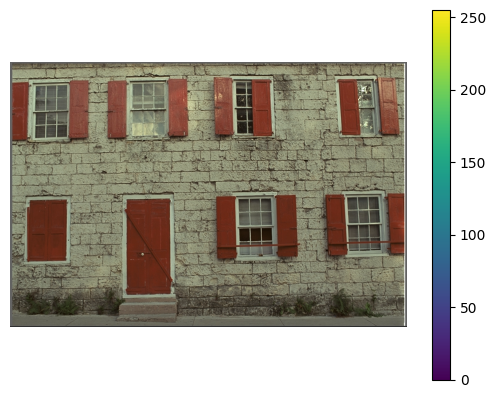

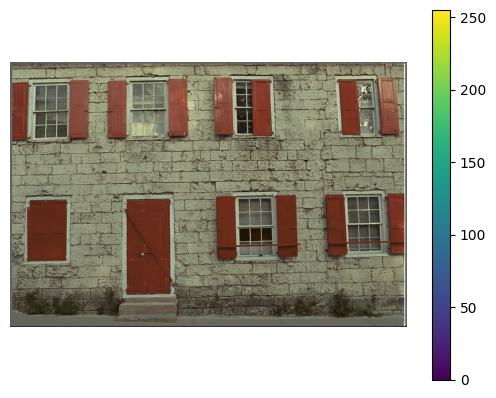

43 0


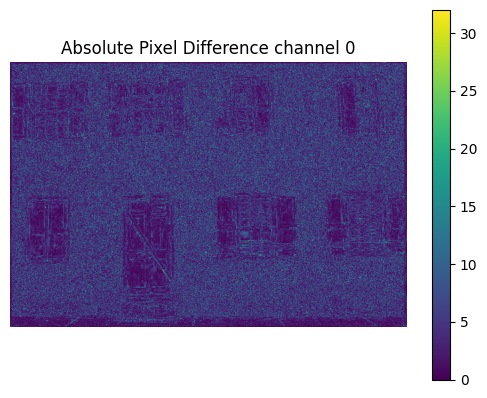

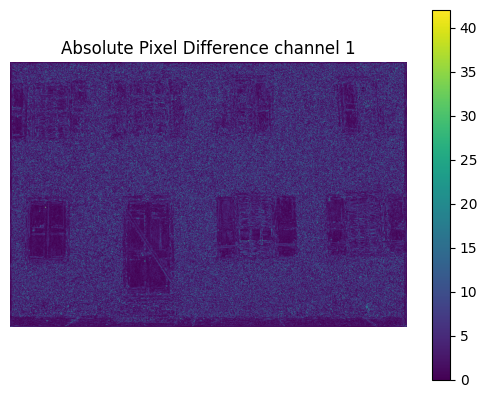

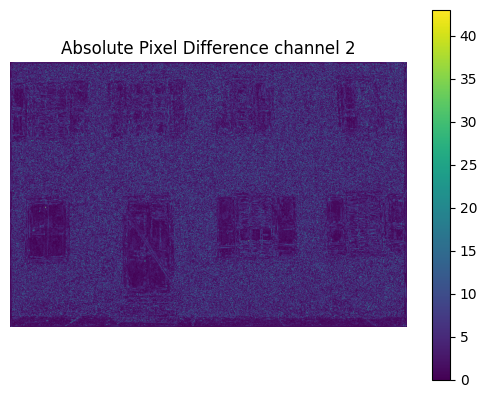

In [7]:
import matplotlib.pyplot as plt

# load IMAGE_PATHS[0] and display it
from PIL import Image
image = Image.open(IMAGE_PATHS[0])
plt.imshow(image)
plt.axis('off')  # Hide axes
plt.colorbar()
plt.show()

# load TEST_WORKDIR + "/0000-decoded-kodim01.png"
decoded_image_path = TEST_WORKDIR + "/0000-decoded-kodim01.png"
decoded_image = Image.open(decoded_image_path)
plt.imshow(decoded_image)
plt.axis('off')  # Hide axes
plt.colorbar()
plt.show()

# plot absolute pixel difference between the original and decoded image
import numpy as np
original_image = np.array(image, dtype=np.int32)
decoded_image = np.array(decoded_image, dtype=np.int32)
# print(original_image[:10, :10, :])
# print(decoded_image[:10, :10, :])

diff_image = np.abs(original_image - decoded_image)
print(np.max(diff_image), np.min(diff_image))
plt.imshow(diff_image[:, :, 0])
plt.axis('off')  # Hide axes
plt.title('Absolute Pixel Difference channel 0')
# add colorbar
plt.colorbar()
plt.show()

plt.imshow(diff_image[:, :, 1])
plt.axis('off')  # Hide axes
plt.title('Absolute Pixel Difference channel 1')
plt.colorbar()
plt.show()
plt.imshow(diff_image[:, :, 2])
plt.axis('off')  # Hide axes
plt.title('Absolute Pixel Difference channel 2')
plt.colorbar()
plt.show()